In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torchvision.transforms import v2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(device)

cuda


In [10]:
#IMAGE VARIABLES
IMG_WIDTH = 64 
IMG_HEIGHT = 64 
BATCH_SIZE = 128
CHANNELS = 3
CLASSES = 10

#NETWORK VAR
SIZE_LATENT = 256
FEATURES_GEN = 64
FEATURES_DIS = 64

#testing variables
seed = 42
NUM_EPOCHS = 10000
LR = 0.0002
BETA1 = 0.5

PATH = '../data-students/TRAIN'

In [11]:
normal_transform = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = datasets.ImageFolder(root=PATH, transform=normal_transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
class_data_loaders = {}
for class_idx in range(CLASSES):
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    class_subset = Subset(dataset, class_indices)
    class_data_loaders[class_idx] = DataLoader(class_subset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(SIZE_LATENT, FEATURES_GEN*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FEATURES_GEN*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN*8, FEATURES_GEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_GEN*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN*4, FEATURES_GEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_GEN*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN*2, FEATURES_GEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_GEN),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(FEATURES_GEN, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is an image size: 3x64x64
        )

    def forward(self, input):
        #input = input.view(-1, self.latent_dim, 1, 1)
        return self.main(input)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        dropout_prob=0.2
        
        self.model = nn.Sequential(
            
            nn.Conv2d(CHANNELS, FEATURES_DIS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS, FEATURES_DIS*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_DIS*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS*2, FEATURES_DIS*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_DIS*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS*4, FEATURES_DIS*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURES_DIS*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_prob),  # Add dropout here
            
            nn.Conv2d(FEATURES_DIS*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)


class DCGAN(nn.Module):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.Generator = Generator()
        self.Discriminator = Discriminator()
        self.losses_G = []
        self.losses_D = []
        

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
def random_zeros(labels, flip_probability):
    # Iterate over each value and flip with the specified probability
    for i in range(len(labels)):
        if random.random() < flip_probability:
            labels[i] = 0
            

In [14]:
models = {}
images_lists = {}
criterion = nn.BCELoss()
model_path = 'models_DCGAN'
os.makedirs(model_path, exist_ok=True)

for class_idx in range(CLASSES):
    models[class_idx] = DCGAN()
    model_path_ = os.path.join(model_path, f"model_DCGAN_{class_idx}.pth")
    models[class_idx].load_state_dict(torch.load(model_path_))
    
print('Loaded pre-trained models\n')

Loaded pre-trained models



In [15]:
def display_comparison_for_class(generator, data_loader, class_idx, device, num_images=10):
    generator = generator.to(device)
    # Get one real image
    real_images, _ = next(iter(data_loader))
    real_image = real_images[0].to(device)
    # Generate fake images
    noise = torch.randn(num_images, SIZE_LATENT, 1, 1, device=device)
    fake_images = generator(noise)
    fig, axes = plt.subplots(1, num_images + 1, figsize=(num_images * 4, 4))
    # Display the real image
    real_img = real_image.cpu().numpy().transpose((1, 2, 0))
    real_img = (real_img + 1) / 2  # Normalize from [-1, 1] to [0, 1]
    axes[0].imshow(real_img)
    axes[0].axis('off')
    axes[0].set_title(f'Real Class {class_idx}')
    
    # Display the generated images
    for i in range(num_images):
        fake_img = fake_images[i].detach().cpu().numpy().transpose((1, 2, 0))
        fake_img = (fake_img + 1) / 2  # Normalize from [-1, 1] to [0, 1]
        axes[i + 1].imshow(fake_img)
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f'Generated {i + 1}')
    
    plt.tight_layout()
    plt.show()


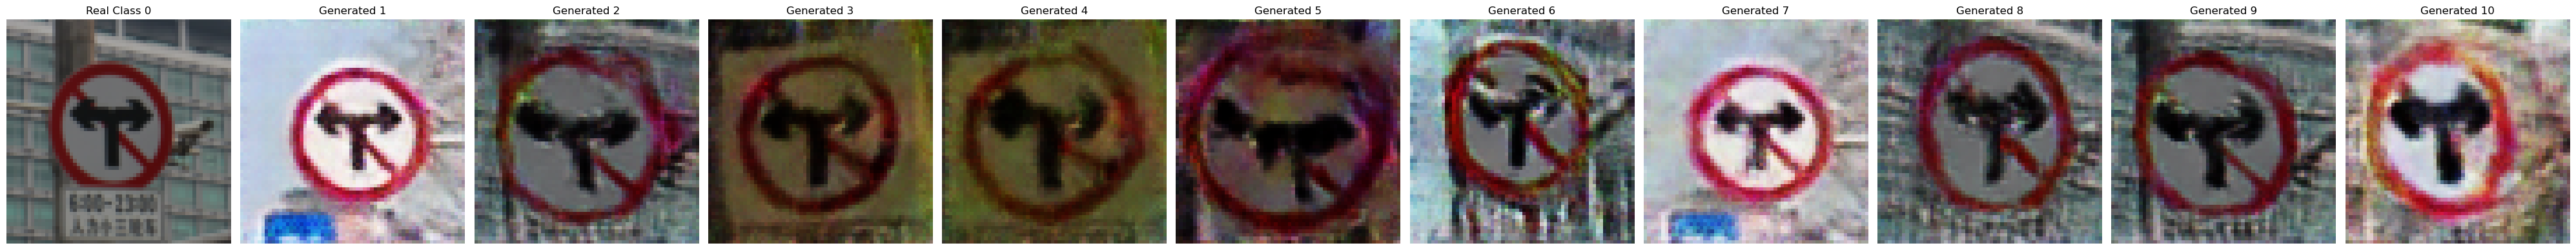

In [16]:
label = 0
# Display real and generated images for the specified class
display_comparison_for_class(models[label].Generator, class_data_loaders[label], label, device, num_images=10)

In [45]:
def generate(models, num_images_per_class, num_classes, latent_dim, device, save=False):
    real_class_names = [12, 13, 24, 38, 39, 44, 46, 49, 50, 6]
    all_generated_images = []
    all_labels = []
    for class_label in range(num_classes):
        model = models[class_label].to(device)
        noise = torch.randn(num_images_per_class, latent_dim, 1, 1, device=device)
        with torch.no_grad():
            generated_images = model.Generator(noise).to(device)
        for i in range(num_images_per_class):
            generated_image = generated_images[i].detach().cpu()
            if save:
                # Denormalize the image from [-1, 1] to [0, 1]
                denormalized_image = (generated_image + 1) / 2
                output_dir = 'generated_dataset/'
                class_path = os.path.join(output_dir, f'{real_class_names[class_label]}')
                os.makedirs(class_path, exist_ok=True)
                image_path = os.path.join(class_path, f'{real_class_names[class_label]}_{i}.png')
                # Save the image
                save_image(denormalized_image, image_path)    
            all_generated_images.append(generated_image)
            all_labels.append(class_label)      
    return all_generated_images, all_labels

In [46]:
def plot_generated_images(all_generated_images, num_images_per_class, num_classes):
    fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(15, 15))
    
    for class_idx in range(num_classes):
        for img_idx in range(num_images_per_class):
            idx = class_idx * num_images_per_class + img_idx
            img = all_generated_images[idx].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize the image to [0, 1]
            axs[class_idx, img_idx].imshow(img)
            axs[class_idx, img_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [47]:
def plot_generated_images_by_class(all_generated_images, num_images_per_class, num_classes):
    for class_idx in range(num_classes):
        fig, axs = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(f'Class {class_idx}')
        
        for img_idx in range(num_images_per_class):
            img = all_generated_images[class_idx * num_images_per_class + img_idx]
            img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize the image to [0, 1]
            ax = axs[img_idx // 3, img_idx % 3]
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplots to fit the title
        plt.show()

In [48]:
def plot_generated_images_with_labels(images_per_class, class_labels):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # Changed from 5x2 to 2x5
    label_str_id = [
        "12",
        "13",
        "24",
        "38",
        "39",
        "44",
        "46",
        "49",
        "50",
        "6"
    ]
    
    for i in range(len(images_per_class)):
        img = images_per_class[i]
        label = label_str_id[i]
        img = (img - img.min()) / (img.max() - img.min())
        row = i // 5  # Calculate row index
        col = i % 5   # Calculate column index
        ax = axs[row, col]
        ax.imshow(img.permute(1, 2, 0))  # Convert from tensor shape (C, H, W) to (H, W, C)
        ax.set_title(f'Class {label}', fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [49]:
size = 1
all_generated_images, all_labels = generate(models, size, CLASSES, SIZE_LATENT, device, False)
#plot_generated_images(all_generated_images, num_images_per_class=9, num_classes=10)
#plot_generated_images_by_class(all_generated_images, num_images_per_class=9, num_classes=10)
#plot_generated_images_with_labels(all_generated_images, all_labels)